[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/seoul-bike-analysis/blob/master/seoul-bike-eda.ipynb)

# 서울특별시 공공자전거 따릉이 대여이력 분석
* [miningful/seoulbike: 따릉이 따세권EDA](https://github.com/miningful/seoulbike)에서 흥미를 얻어 분석을 시작하게 됨

## 데이터 출처 :
* 서울특별시 공공자전거 대여이력 정보
http://data.seoul.go.kr/dataList/datasetView.do?infId=OA-15182&srvType=F&serviceKind=1&currentPageNo=1

* `(이달의주요공개정보)_서울_공공자전거(따릉이)_이용현황 자료(161021).xlsx (1.24MB)`
https://opengov.seoul.go.kr/anspruch/10045476


## 관련자료 
* [(석간) 서울시 따릉이 회원 62만 돌파 출 퇴근시간 38% 집중](http://spp.seoul.go.kr/main/news/news_report.jsp#view/253821)
* [공공자전거 따릉이 인기 따라 '따세권' 형성…소외지역도 :: 공감언론 뉴시스통신사 ::](http://www.newsis.com/view/?id=NISX20180706_0000356247&cID=10201&pID=10200)
* [서울특별시 빅데이터 캠퍼스 > 분석결과/사례공유 > 서울시 분석사례 > 서울시 자전거 이동경로 분석](https://bigdata.seoul.go.kr/noti/selectNoti.do?r_id=P430&bbs_seq=229&sch_type=&sch_text=&currentPage=1)
* [따릉이 편리하게 이용하기 위한 14가지 | 서울시 정보소통광장(정보공개)](https://opengov.seoul.go.kr/mediahub/15085803)

## 주석풀기
* control + A , control + /

In [0]:
# 노트북이 간결해 보이도록 경고 문구는 출력되지 않도록 함
# 프로그래밍에 익숙하다면 경고 문구도 출력해서 보도록 한다. 
# 하지만 익숙하지 않다면 당황하지 않기 위해 경고 메시지는 찍히지 않도록 한다.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 사용할 도구 가져오기

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

### 시각화 도구 설정

In [0]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
# Window 의 한글 폰트 설정
# plt.rc('font',family='Malgun Gothic')
# Mac 의 한글 폰트 설정
plt.rc('font', family='AppleGothic') 
plt.rc('axes', unicode_minus=False)

set_matplotlib_formats('retina')


# 그래프가 노트북 안에 보이게 하기 위해
%matplotlib inline

## Colab 에서 실행을 위한 코드

* https://colab.research.google.com/github/corazzon/seoul-bike-analysis/blob/master/seoul-bike-eda.ipynb
* 아래의 코드는 google colaboratory 에서 실행을 위한 코드로 로컬 아나콘다에서는 주석처리한다.
* google colaboratory 에서는 주석을 풀고 폰트 설정과 csv 파일을 불러온다.

In [4]:
# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null

import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [9]:
# 구글 드라이브에서 csv 파일을 읽어오기 위해 gauth 인증을 한다.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# PyDrive client 인증
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.1MB/s 


In [10]:
# 공유 가능한 링크로 파일 가져오기 - 대여정보

url ='https://drive.google.com/open?id=1YCIUZohmLJCVMtBhYpZf5aVnYGJC1USn'
id = url.split('=')[1]
print(id)
downloaded = drive.CreateFile({'id':id}) 

# data 폴더에 파일을 관리하며, 폴더가 없다면 만들어서 파일을 관리하도록 한다.

%mkdir data
downloaded.GetContentFile('data/seoul-bike-2016.csv')  

1YCIUZohmLJCVMtBhYpZf5aVnYGJC1USn


In [11]:
# 공유 가능한 링크로 파일 가져오기 - 대여소 정보

url ='https://drive.google.com/open?id=1PbU3obWSNc7ADD2sAF2Anhb9HYH8JsDL'
id = url.split('=')[1]
print(id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data/seoul_bike_station.csv')  

1PbU3obWSNc7ADD2sAF2Anhb9HYH8JsDL


## 데이터 불러오기
* 서울시정보소통광장에서 다운로드 받은 csv파일과 크롤링해온 대여소 정보가 있다.
* 이 노트북에서는 전체 데이터 중 일부 데이터만을 사용해서 특정 시기의 데이터만 분석해 보고 점점 더 큰 데이터를 로드해서 분석한다.

In [12]:
# df = pd.read_csv('data/서울특별시 공공자전거 대여이력 정보_2018년_2분기_4.csv', encoding='cp949')
# 2018년 2분기까지의 데이터를 보고 싶다면 아래 파일을 불러온다.

%time df = pd.read_csv('data/seoul-bike-2016.csv', low_memory=False)
df.shape

CPU times: user 3.92 s, sys: 514 ms, total: 4.43 s
Wall time: 4.44 s


(1580480, 11)

## 데이터 미리보기 및 요약하기
* head와 tail을 통해 데이터 미리보기를 해볼 수 있다.
* head는 데이터의 윗부분을 tail은 데이터의 하단부를 미리보기 해준다. 
* 괄호안에 숫자를 넣어주면 해당 숫자만큼의 데이터를 가져온다. 기본값은 5이다.

In [92]:
df.head(3)

,자전거번호,대여일시,대여대여소번호,대여대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),대여년월일,반납년월일,대여년,대여월,대여일,대여시,대여분,대여요일,반납년,반납월,반납일,반납시,반납분,반납요일,같은대여반납소
0,SPB-01338,2016-01-01 00:12:00,112,극동방송국 앞,4,2016-01-01 00:38:00,137,NH농협 신촌지점 앞,5,24,4140,2016-01-01,2016-01-01,2016,1,1,0,12,4,2016,1,1,0,38,4,False
1,SPB-00381,2016-01-01 00:22:00,113,홍대입구역 2번출구 앞,6,2016-01-01 00:47:00,137,NH농협 신촌지점 앞,9,24,2850,2016-01-01,2016-01-01,2016,1,1,0,22,4,2016,1,1,0,47,4,False
2,SPB-01069,2016-01-01 00:23:00,211,여의도역 4번출구 옆,11,2016-01-01 00:30:00,216,삼부아파트1동 앞,10,7,1020,2016-01-01,2016-01-01,2016,1,1,0,23,4,2016,1,1,0,30,4,False


In [14]:
df.tail()

,자전거번호,대여일시,대여대여소번호,대여대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M)
1580475,SPB-03818,2016-12-31 23:57,199,서울 월드컵 경기장,24,2017-01-01 0:06,412,DMC산학협력연구센터 앞,14,8,1490
1580476,SPB-04354,2016-12-31 23:57,115,사루비아 빌딩 앞,9,2017-01-01 0:02,128,신촌역(2호선) 1번출구 옆,16,4,1100
1580477,SPB-03102,2016-12-31 23:58,623,서울시립대 정문 앞,10,2017-01-01 0:01,639,서울시립대 후문,9,3,770
1580478,SPB-01266,2016-12-31 23:58,320,을지로입구역 4번출구 앞,7,2017-01-01 0:05,320,을지로입구역 4번출구 앞,7,7,740
1580479,SPB-02604,2016-12-31 23:58,340,혜화동 로터리,7,2017-01-01 0:20,330,청계천 한빛광장,6,21,5060


* info를 사용하면 해당 데이터의 요약정보를 볼 수 있다.
* 데이터의 갯수와 데이터의 타입, 크기 등을 볼 수 있다.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580480 entries, 0 to 1580479
Data columns (total 11 columns):
자전거번호      1580480 non-null object
대여일시       1580480 non-null object
대여대여소번호    1580480 non-null object
대여대여소명     1580480 non-null object
대여거치대      1580480 non-null int64
반납일시       1580480 non-null object
반납대여소번호    1580480 non-null object
반납대여소명     1580480 non-null object
반납거치대      1580480 non-null int64
이용시간(분)    1580480 non-null int64
이용거리(M)    1580480 non-null int64
dtypes: int64(4), object(7)
memory usage: 132.6+ MB


In [16]:
df[["이용시간(분)", "이용거리(M)"]].describe()

,이용시간(분),이용거리(M)
count,1.580480e+06,1.580480e+06
mean,2.649839e+01,3.409113e+03
std,3.015963e+01,3.632846e+03
min,2.000000e+00,0.000000e+00
25%,8.000000e+00,1.160000e+03
50%,1.600000e+01,2.160000e+03
75%,3.800000e+01,4.400000e+03
max,1.518000e+03,2.499500e+05


In [17]:
df.describe(include=np.object)

,자전거번호,대여일시,대여대여소번호,대여대여소명,반납일시,반납대여소번호,반납대여소명
count,1580480,1580480,1580480,1580480,1580480,1580480,1580480
unique,4954,357431,454,454,355652,457,457
top,SPB-00438,2016-10-15 16:35,207,여의나루역 1번출구 앞,2016-10-03 18:28,207,여의나루역 1번출구 앞
freq,701,53,36728,36728,87,38207,38207


## 분석을 위한 전처리
* 위에서 데이터를 미리보기 했을 때 컬럼과 데이터에 불필요한 홑따옴표가 포함되어 있다.
* 전처리를 통해 제거해 준다.
* object 타입의 데이터에는 모두 홑따옴표가 들어가 있다. 따라서 object 데이터 타입이라면 홑따옴표를 제거해 주도록 한다.
* 아래 코드는 데이터를 병합하면서 처리했다. 병합 전의 데이터를 불러와서 전처리 하고자 할 때는 주석을 풀고 사용하면 된다.

In [0]:
# 컬럼에 있는 '를 제거한다.
df.columns = df.columns.str.strip("'")

In [0]:
# 일부 데이터에 불필요하게 '가 들어가 있다. 스트링 타입으로 되어있는 데이터에서 '을 제거하자.
# 2018년 전체 데이터를 모아놓은 csv에서는 미리 제거해서 넣어두었다.
# 다른 파일을 가져와서 분석할 때 아래 코드를 활용한다.

df = df.apply(lambda x: x.str.strip("'") if x.dtype == np.dtype('object') else x)

# 다음의 방법으로 제거할 수도 있다.

df.iloc[:, :4] = df.iloc[:, :4].apply(lambda x: x.str.strip("'"))
df.iloc[:, 5:8] = df.iloc[:, 5:8].apply(lambda x: x.str.strip("'"))

## 결측치 보기

In [20]:
df.isnull().sum()

자전거번호      0
대여일시       0
대여대여소번호    0
대여대여소명     0
대여거치대      0
반납일시       0
반납대여소번호    0
반납대여소명     0
반납거치대      0
이용시간(분)    0
이용거리(M)    0
dtype: int64

## 결측치 시각화 하기
* missingno는 별도로 설치해야 하는 시각화 도구 입니다. 결측치를 시각화해서 볼 수 있다.

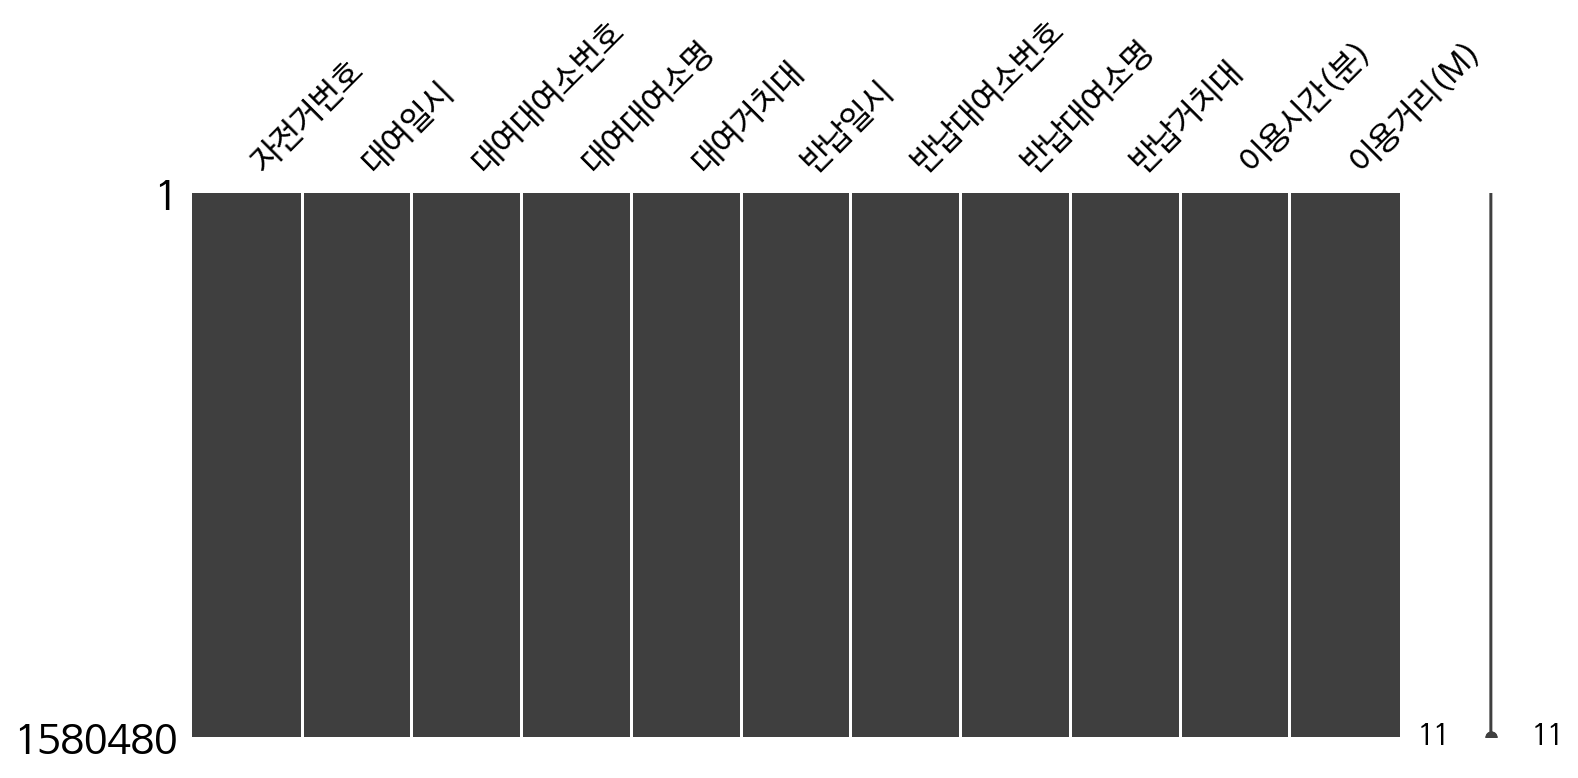

In [21]:
# 아나콘다에서 missingno 설치가 안 되어 있다면 다음의 명령으로 설치합니다.
# https://anaconda.org/conda-forge/missingno
# conda install -c conda-forge missingno

# 결측치 보기
import missingno as msno

msno.matrix(df, figsize=(12,5))

## 대여소별 대여|반납 현황

In [22]:
print('# 대여소 수')
print('대여 대여소: ', df['대여대여소번호'].unique().shape[0])
print('반납 대여소: ', df['반납대여소번호'].unique().shape[0])

# 대여소 수
대여 대여소:  454
반납 대여소:  457


In [23]:
df['대여대여소번호'].value_counts().tail(10)

상암센터 정비실    172
918         169
930         151
929         139
603          84
270          79
중랑센터         50
632          15
588          12
1             1
Name: 대여대여소번호, dtype: int64

* 대여 대여소번호에 상암센터 정비실과 위트콤 같은 숫자가 아닌 곳들이 있음

In [24]:
# 대여량이 많은 상위 대여소
df['대여대여소명'].value_counts().head(10)

 여의나루역 1번출구 앞     36728
 뚝섬유원지역 1번출구 앞    25533
 홍대입구역 2번출구 앞     21861
 누리꿈스퀘어 옆         13126
 서울숲역 4번 출구 옆     12984
 홈플러스 앞           12897
 혜화동 로터리          12784
 IFC몰             11836
 DMC역 9번출구 앞      11279
 여의도역 4번출구 옆      11253
Name: 대여대여소명, dtype: int64

In [25]:
# 반납량이 많은 상위 대여소
df['반납대여소명'].value_counts().head(10)

 여의나루역 1번출구 앞     38207
 뚝섬유원지역 1번출구 앞    28066
 홍대입구역 2번출구 앞     23574
 혜화동 로터리          14000
 누리꿈스퀘어 옆         13761
 서울숲역 4번 출구 옆     13248
 국민일보 앞           12947
 IFC몰             12531
 홈플러스 앞           12141
 마포구청 앞           11766
Name: 반납대여소명, dtype: int64

1. 대여반납이 많은 상위 대여소인 홍대입구역, 여의나루역, 뚝섬유원지, 롯데월드타워는 모두 강이나 호수를 인근에 두고 있다. 
2. 성대입구나 안암로터리 버스정류장은 대학가 인근이다.

In [26]:
# 평균 이용거리가 긴 상위 대여소
df.groupby(['대여대여소명'])['이용거리(M)'].mean().reset_index().sort_values(
    by='이용거리(M)', ascending=False).head(10)

,대여대여소명,이용거리(M)
425,한남 유수지 복개주차장,8150.510685
318,옥수역 3번출구,7828.353383
200,서빙고동 주민센터 앞,7814.491882
88,달맞이공원,7763.366733
11,KB국민은행 염창역 지점 앞,7463.817006
19,LIG강촌아파트 103동앞,7211.811159
426,한남초교 앞 보도육교,7051.005917
441,홍은동 정원여중 입구,7034.454454
199,서빙고동 금호맨션 앞,6869.882180
353,이촌1동 마을공원,6762.943886


In [27]:
# 평균 이동거리가 긴 구룡마을 입구에서 대여한 자전거의 반납 장소를 본다.
df.loc[df["대여대여소명"] == "구룡마을 입구 (래미안블레스티지 아파트)", "반납대여소명"]

Series([], Name: 반납대여소명, dtype: object)

In [28]:
# 평균 이용거리가 긴 상위 반납대여소
df.groupby(['반납대여소명'])['이용거리(M)'].mean().reset_index().sort_values(
    by='이용거리(M)', ascending=False).head(10)

,반납대여소명,이용거리(M)
201,서빙고동 주민센터 앞,8539.095685
29,가회동 주민센터 옆(미설치),8486.666667
200,서빙고동 금호맨션 앞,7976.492347
89,달맞이공원,7820.639924
11,KB국민은행 염창역 지점 앞,7778.793378
19,LIG강촌아파트 103동앞,7717.055596
319,옥수역 3번출구,7700.070770
428,한남 유수지 복개주차장,7698.904538
30,강변역 4번출구 뒤,7516.348705
356,이촌1동 마을공원,7066.586022


In [29]:
# 평균 이용거리가 짧은 대여소
df.groupby(['대여대여소명'])['이용거리(M)'].mean().reset_index().sort_values(
    by='이용거리(M)', ascending=True).head()

,대여대여소명,이용거리(M)
453,중랑센터,53.400000
450,상암센터 정비실,80.116279
451,서울자전거(행사용),980.000000
332,원남동사거리,1768.373966
80,낙원상가 옆,1822.071670


In [30]:
# 평균 이용시간이 많은 상위 대여소
df.groupby(['대여대여소명'])['이용시간(분)'].mean().reset_index().sort_values(
    by='이용시간(분)', ascending=False).head()

,대여대여소명,이용시간(분)
411,청량리역 3번출구 앞,70.666667
19,LIG강촌아파트 103동앞,56.439485
296,여의도중학교 옆,54.046688
201,서울 월드컵 경기장,54.022340
208,서울숲 남문 버스정류소 옆,53.627525


In [31]:
# 평균 이용시간이 적은 상위 대여소
df.groupby(['대여대여소명'])['이용시간(분)'].mean().reset_index().sort_values(
    by='이용시간(분)', ascending=True).head()

,대여대여소명,이용시간(분)
453,중랑센터,8.260000
451,서울자전거(행사용),12.000000
450,상암센터 정비실,12.255814
6,DMC역 9번출구 앞,12.914531
157,봉원고가차도 밑,13.522826


## 시계열 데이터 보기
* Datetime 활용하기 : [pandas.DatetimeIndex — pandas 0.24.2 documentation](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DatetimeIndex.html)

In [32]:
# 날짜와 시간이 object 타입이다.
# 연, 월, 일, 시, 분, 초, 요일 등의 정보를 가져오기 위해 데이터의 타입을 변경한다.
df['대여일시'] = pd.to_datetime(df['대여일시'])
df['반납일시'] = pd.to_datetime(df['반납일시'])
df.dtypes

자전거번호              object
대여일시       datetime64[ns]
대여대여소번호            object
대여대여소명             object
대여거치대               int64
반납일시       datetime64[ns]
반납대여소번호            object
반납대여소명             object
반납거치대               int64
이용시간(분)             int64
이용거리(M)             int64
dtype: object

In [33]:
df['대여년월일'] = df['대여일시'].dt.date
df['반납년월일'] = df['반납일시'].dt.date
df['대여년'] = df['대여일시'].dt.year
df['대여월'] = df['대여일시'].dt.month
df['대여일'] = df['대여일시'].dt.day
df['대여시'] = df['대여일시'].dt.hour
df['대여분'] = df['대여일시'].dt.minute
df['대여요일'] = df['대여일시'].dt.dayofweek
df.columns

Index(['자전거번호', '대여일시', '대여대여소번호', '대여대여소명', '대여거치대', '반납일시', '반납대여소번호',
       '반납대여소명', '반납거치대', '이용시간(분)', '이용거리(M)', '대여년월일', '반납년월일', '대여년', '대여월',
       '대여일', '대여시', '대여분', '대여요일'],
      dtype='object')

In [34]:
df['반납년월일'] = df['반납일시'].dt.date
df['반납년월일'] = df['반납일시'].dt.date
df['반납년'] = df['반납일시'].dt.year
df['반납월'] = df['반납일시'].dt.month
df['반납일'] = df['반납일시'].dt.day
df['반납시'] = df['반납일시'].dt.hour
df['반납분'] = df['반납일시'].dt.minute
df['반납요일'] = df['반납일시'].dt.dayofweek
df.columns

Index(['자전거번호', '대여일시', '대여대여소번호', '대여대여소명', '대여거치대', '반납일시', '반납대여소번호',
       '반납대여소명', '반납거치대', '이용시간(분)', '이용거리(M)', '대여년월일', '반납년월일', '대여년', '대여월',
       '대여일', '대여시', '대여분', '대여요일', '반납년', '반납월', '반납일', '반납시', '반납분', '반납요일'],
      dtype='object')

In [35]:
df.head()

,자전거번호,대여일시,대여대여소번호,대여대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),대여년월일,반납년월일,대여년,대여월,대여일,대여시,대여분,대여요일,반납년,반납월,반납일,반납시,반납분,반납요일
0,SPB-01338,2016-01-01 00:12:00,112,극동방송국 앞,4,2016-01-01 00:38:00,137,NH농협 신촌지점 앞,5,24,4140,2016-01-01,2016-01-01,2016,1,1,0,12,4,2016,1,1,0,38,4
1,SPB-00381,2016-01-01 00:22:00,113,홍대입구역 2번출구 앞,6,2016-01-01 00:47:00,137,NH농협 신촌지점 앞,9,24,2850,2016-01-01,2016-01-01,2016,1,1,0,22,4,2016,1,1,0,47,4
2,SPB-01069,2016-01-01 00:23:00,211,여의도역 4번출구 옆,11,2016-01-01 00:30:00,216,삼부아파트1동 앞,10,7,1020,2016-01-01,2016-01-01,2016,1,1,0,23,4,2016,1,1,0,30,4
3,SPB-00559,2016-01-01 00:24:00,113,홍대입구역 2번출구 앞,5,2016-01-01 00:47:00,137,NH농협 신촌지점 앞,5,22,2850,2016-01-01,2016-01-01,2016,1,1,0,24,4,2016,1,1,0,47,4
4,SPB-00492,2016-01-01 00:35:00,335,종로3가역 15번출구 앞,2,2016-01-01 00:55:00,343,예일빌딩(율곡로) 앞,1,19,2190,2016-01-01,2016-01-01,2016,1,1,0,35,4,2016,1,1,0,55,4


In [36]:
df_month_1 = df['대여월'].value_counts().reset_index()
df_month_1.columns = ['month', 'count']

df_month_1 = df_month_1.sort_values('month')
df_month_1['대여반납'] = '대여'
print(df_month_1.shape)

df_month_2 = df['반납월'].value_counts().reset_index()
df_month_2.columns = ['month', 'count']
df_month_2 = df_month_2.sort_values('month')
df_month_2['대여반납'] = '반납'
print(df_month_2.shape)

df_month = pd.concat([df_month_1, df_month_2])
print(df_month.shape)
df_month.head()

(12, 3)
(12, 3)
(24, 3)


,month,count,대여반납
10,1,17336,대여
11,2,16953,대여
9,3,49582,대여
8,4,79601,대여
7,5,93050,대여


In [37]:
df_month_pivot =  df_month.pivot_table(index=['month'],
                                       columns=['대여반납'], 
                                       values='count', aggfunc=sum)
df_month_pivot

대여반납,대여,반납
month,,
1,17336,17352
2,16953,16952
3,49582,49552
4,79601,79570
5,93050,93067
6,104284,104280
7,122184,122116
8,201157,201167
9,310263,310142


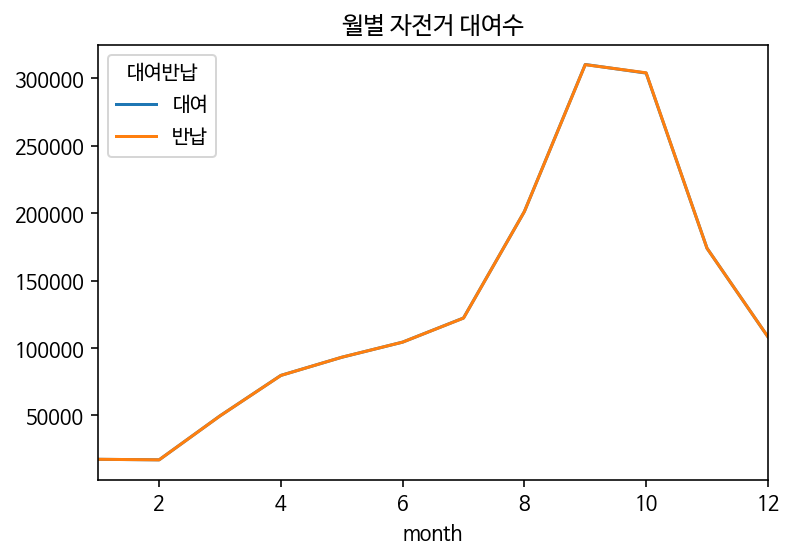

In [38]:
df_month_pivot.plot(title='월별 자전거 대여수', rot=0)

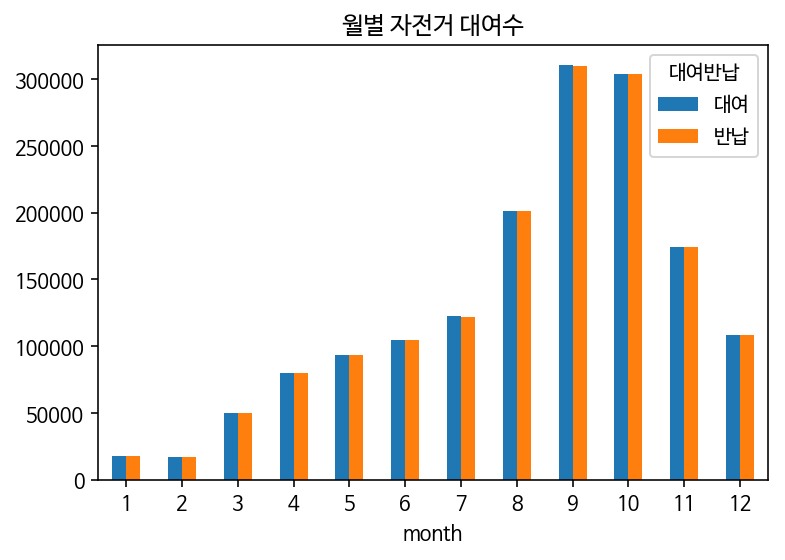

In [39]:
df_month_pivot.plot.bar(title='월별 자전거 대여수', rot=0)

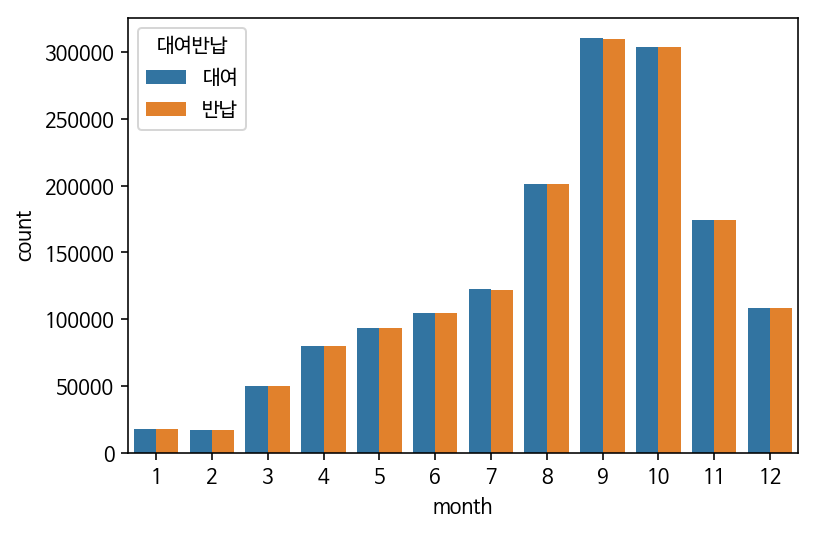

In [40]:
sns.barplot(data=df_month, x='month', y='count', hue='대여반납')

## 일자별 대여|반납 현황
* 날짜에 따라 대여|반납 횟수를 확인한다.

In [41]:
df_day_1 = df['대여일'].value_counts().reset_index()
df_day_1.columns = ['day', 'count']

df_day_1 = df_day_1.sort_values('day')
df_day_1['대여반납'] = '대여'
print(df_day_1.shape)

df_day_2 = df['반납일'].value_counts().reset_index()
df_day_2.columns = ['day', 'count']
df_day_2 = df_day_2.sort_values('day')
df_day_2['대여반납'] = '반납'
print(df_day_2.shape)

df_day = pd.concat([df_day_1, df_day_2])
print(df_day.shape)
df_day.head()

(31, 3)
(31, 3)
(62, 3)


,day,count,대여반납
13,1,53198,대여
28,2,42987,대여
9,3,54313,대여
7,4,55210,대여
12,5,53247,대여


In [42]:
df_day_pivot =  df_day.pivot_table(index=['day'],
                                       columns=['대여반납'], 
                                       values='count', aggfunc=sum)
df_day_pivot.head()

대여반납,대여,반납
day,,
1,53198,53080
2,42987,43196
3,54313,53995
4,55210,55365
5,53247,53244


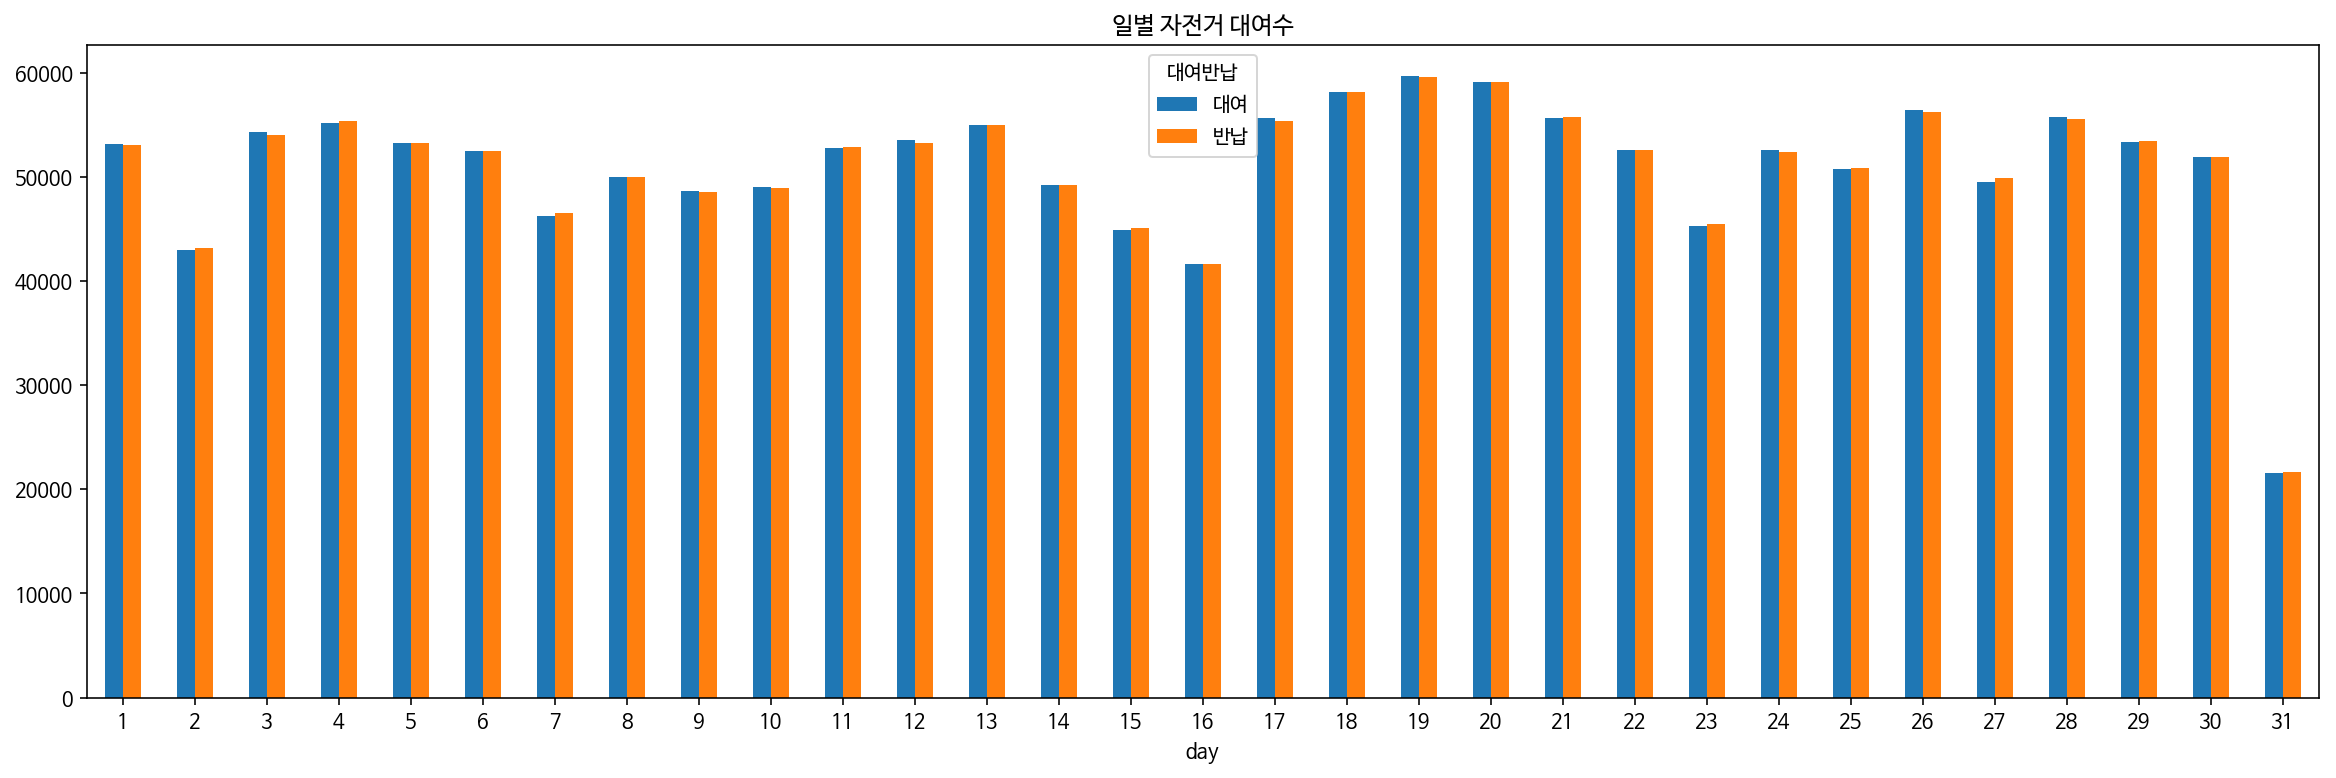

In [43]:
df_day_pivot.plot.bar(title='일별 자전거 대여수', rot=0, figsize=(20, 6))

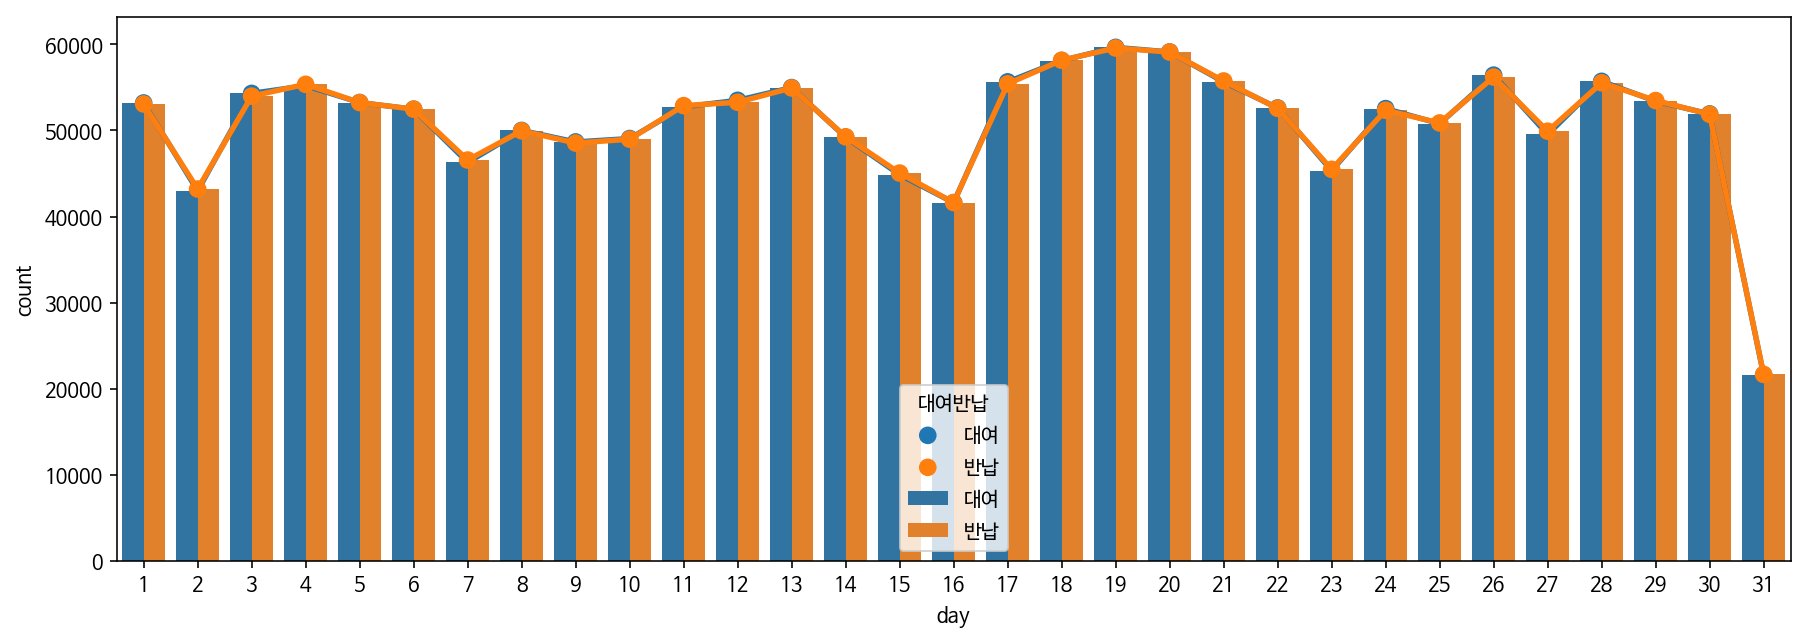

In [44]:
plt.figure(figsize=(15, 5))
sns.pointplot(data=df_day, x='day', y='count', hue='대여반납')
sns.barplot(data=df_day, x='day', y='count', hue='대여반납')

In [45]:
df_ymd_1 = df['대여년월일'].value_counts().reset_index()
df_ymd_1.columns = ['ymd', 'count']

df_ymd_1 = df_ymd_1.sort_values('ymd')
df_ymd_1['대여반납'] = '대여'
print(df_ymd_1.shape)

df_ymd_2 = df['반납년월일'].value_counts().reset_index()
df_ymd_2.columns = ['ymd', 'count']
df_ymd_2 = df_ymd_2.sort_values('ymd')
df_ymd_2['대여반납'] = '반납'
print(df_ymd_2.shape)

df_ymd = pd.concat([df_ymd_1, df_ymd_2])
print(df_ymd.shape)
df_ymd.head()

(366, 3)
(367, 3)
(733, 3)


,ymd,count,대여반납
340,2016-01-01,500,대여
317,2016-01-02,722,대여
326,2016-01-03,654,대여
303,2016-01-04,804,대여
311,2016-01-05,752,대여


In [0]:
# 시간데이터로 표현하기 위해 타입을 바꿔준다.
df_ymd["ymd"] = pd.to_datetime(df_ymd["ymd"])
df_ymd["yymmdd"] = df_ymd["ymd"].dt.date

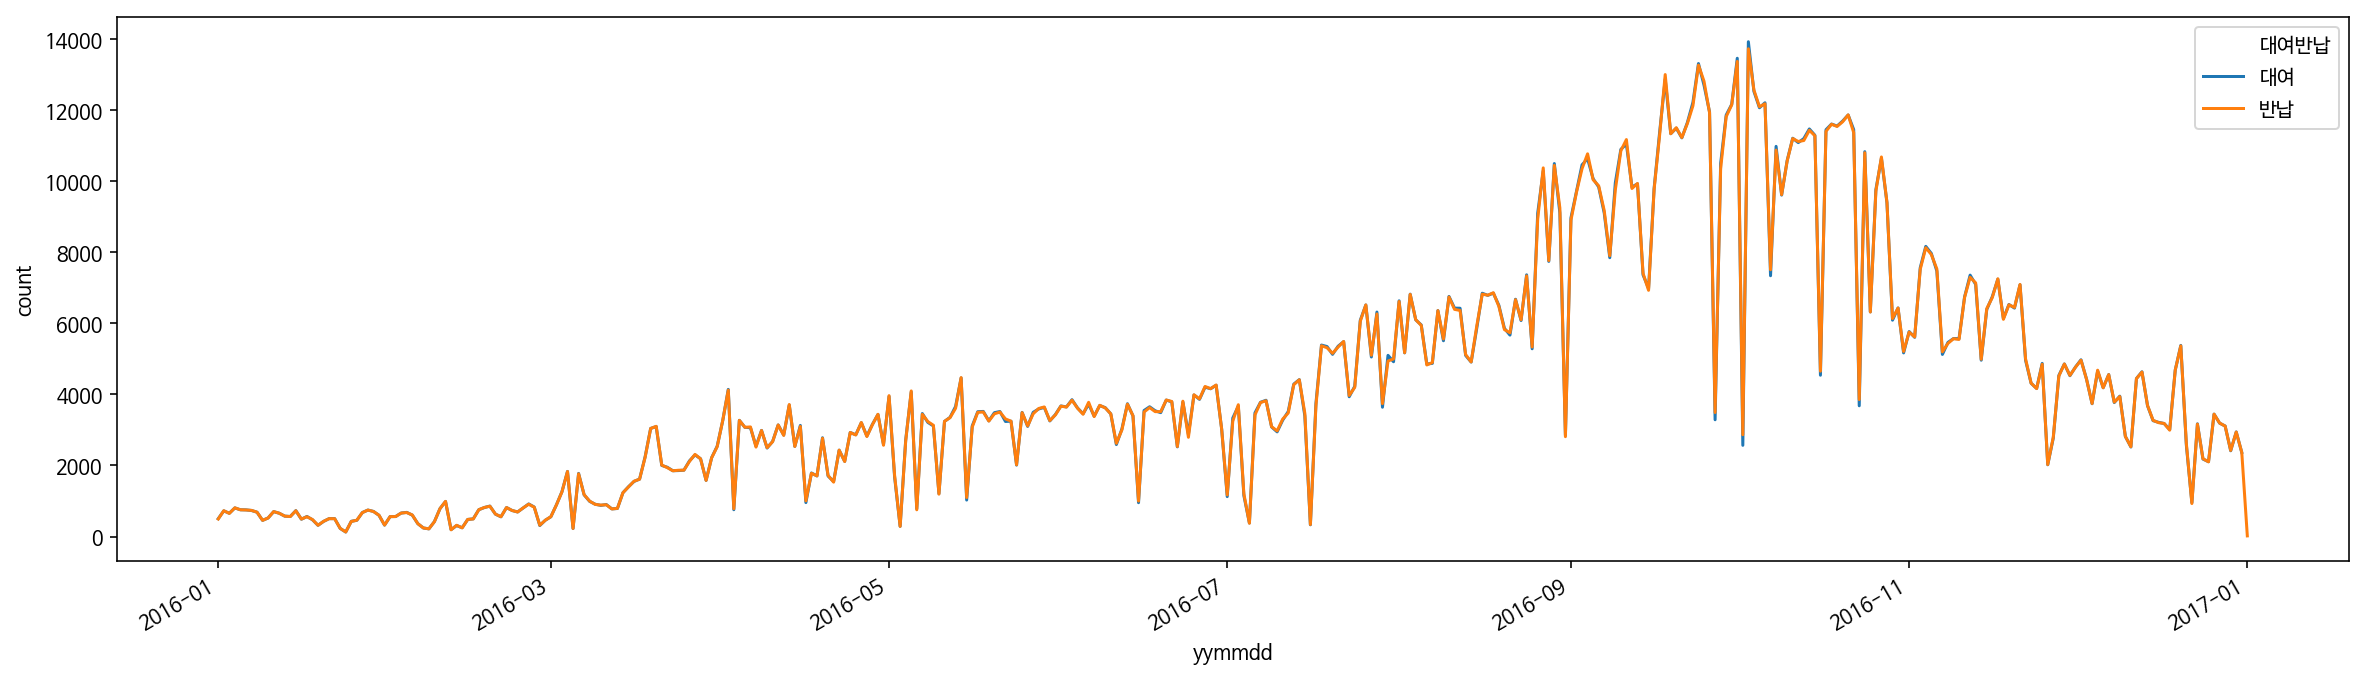

In [48]:
plt.figure(figsize=(20, 5))
plt.xticks(rotation=30, ha='right')
sns.lineplot(data=df_ymd, x='yymmdd', y='count', hue='대여반납')

In [49]:
# 슬라이싱으로 최근 데이터를 불러오기 위해 날짜 기준으로 정렬되도록 한다.
df_ymd = df_ymd.sort_values(by="ymd")
df_ymd.head()

,ymd,count,대여반납,yymmdd
340,2016-01-01,500,대여,2016-01-01
341,2016-01-01,493,반납,2016-01-01
316,2016-01-02,726,반납,2016-01-02
317,2016-01-02,722,대여,2016-01-02
326,2016-01-03,650,반납,2016-01-03


* 일부 날짜의 데이터만 있다.
* 2018년 6월 데이터만 봤을 때 13, 26일에는 대여와 반납모두 적다.
* 26일의 일기예보를 보면 장맛비가 내린것을 확인해 볼 수 있다. https://www.youtube.com/watch?v=cYHC8iwfFyU

## 요일별 대여|반납 현황
* 대여|반납별로 어떤 요일에 주로 대여반납이 되는지 시각화해보기 위해 Tidy Data를 만든다.

In [50]:
df_dow_1 = df['대여요일'].value_counts().reset_index()
df_dow_1.columns = ['dayofweek', 'count']
df_dow_1 = df_dow_1.sort_values('dayofweek')
df_dow_1['대여반납'] = '대여'
print(df_dow_1.shape)

df_dow_2 = df['반납요일'].value_counts().reset_index()
df_dow_2.columns = ['dayofweek', 'count']
df_dow_2 = df_dow_2.sort_values('dayofweek')
df_dow_2['대여반납'] = '반납'
print(df_dow_2.shape)

df_dow = pd.concat([df_dow_1, df_dow_2]).reindex()
print(df_dow.shape)

(7, 3)
(7, 3)
(14, 3)


In [51]:
df_dow.head(3)

,dayofweek,count,대여반납
0,0,238310,대여
5,1,217367,대여
4,2,223863,대여


In [52]:
df_dow.tail(3)

,dayofweek,count,대여반납
1,4,235699,반납
3,5,231050,반납
6,6,201992,반납


In [53]:
weekday_map = {0:'월', 1:'화', 2:'수', 3:'목',
              4:'금', 5:'토', 6:'일'}
df_dow['weekday'] = df_dow['dayofweek'].apply(lambda x : weekday_map[x])
df_dow[['dayofweek', 'weekday']].head()

,dayofweek,weekday
0,0,월
5,1,화
4,2,수
2,3,목
1,4,금


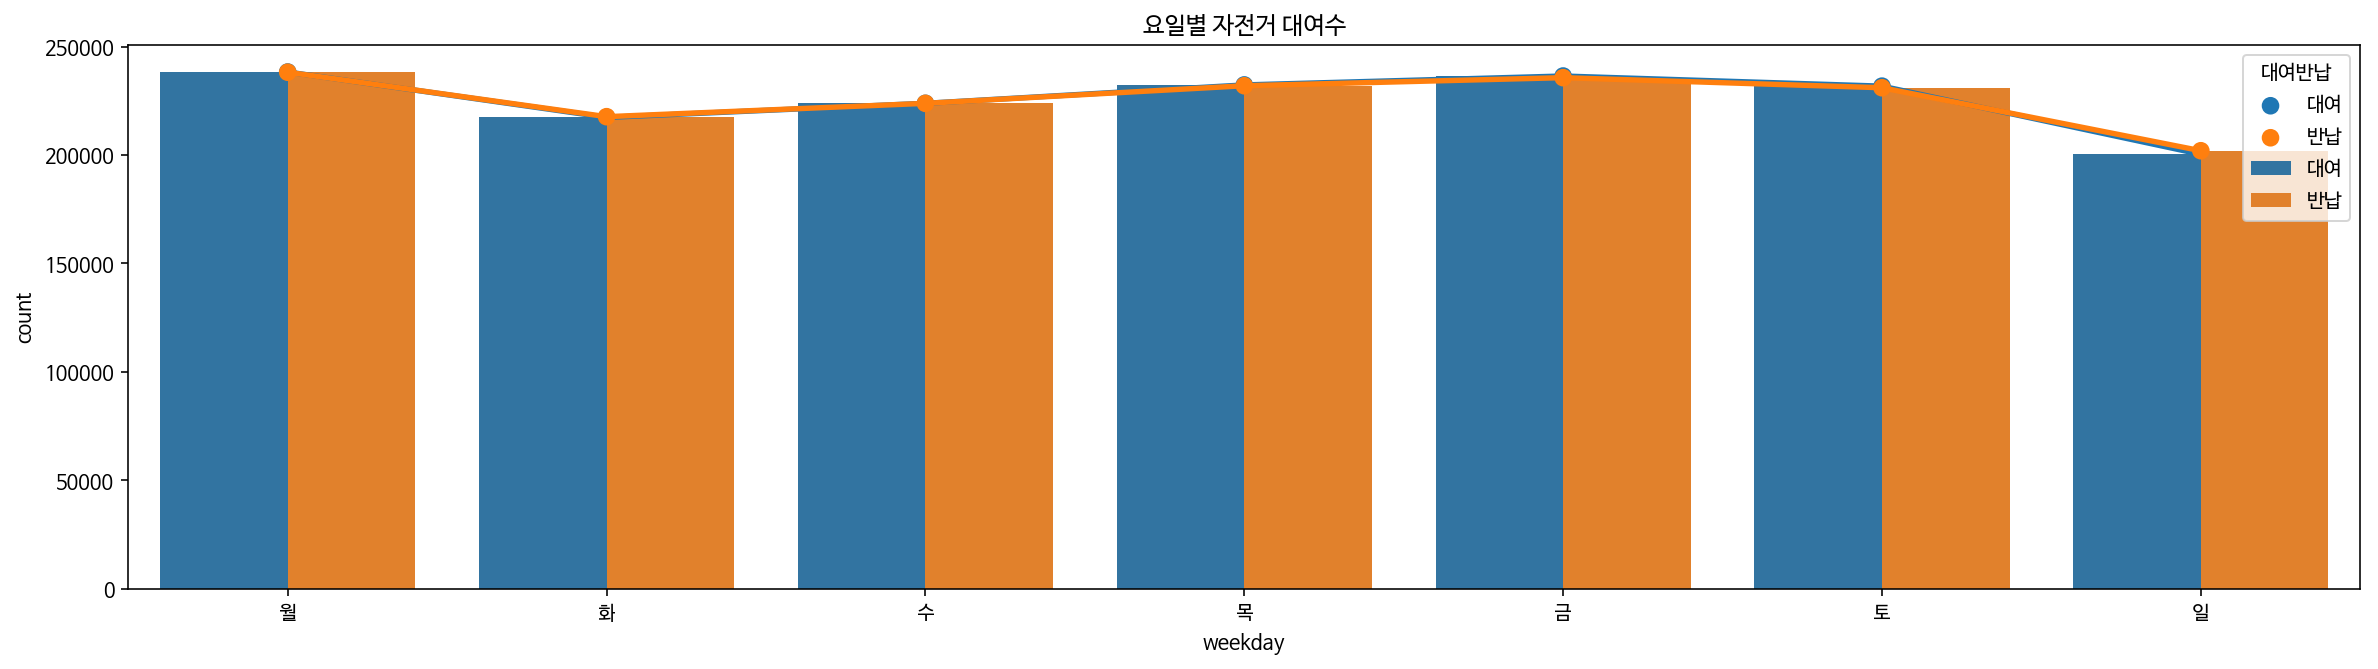

In [54]:
plt.figure(figsize=(20, 5))
plt.title("요일별 자전거 대여수")
sns.pointplot(data=df_dow, x="weekday", y="count", hue="대여반납")
sns.barplot(data=df_dow, x="weekday", y="count", hue="대여반납")

## 시간대별 대여|반납량

In [55]:
df_hour_1 = df['대여시'].value_counts().reset_index()
df_hour_1.columns = ['hour', 'count']
df_hour_1 = df_hour_1.sort_values('hour')
df_hour_1['대여반납'] = '대여'
df_hour_1.head()

df_hour_2 = df['반납시'].value_counts().reset_index()
df_hour_2.columns = ['hour', 'count']
df_hour_2 = df_hour_2.sort_values('hour')
df_hour_2['대여반납'] = '반납'
df_hour_2.head()

df_hour = pd.concat([df_hour_1, df_hour_2])
df_hour.head()

,hour,count,대여반납
17,0,40167,대여
18,1,25052,대여
20,2,17259,대여
21,3,11086,대여
23,4,7900,대여


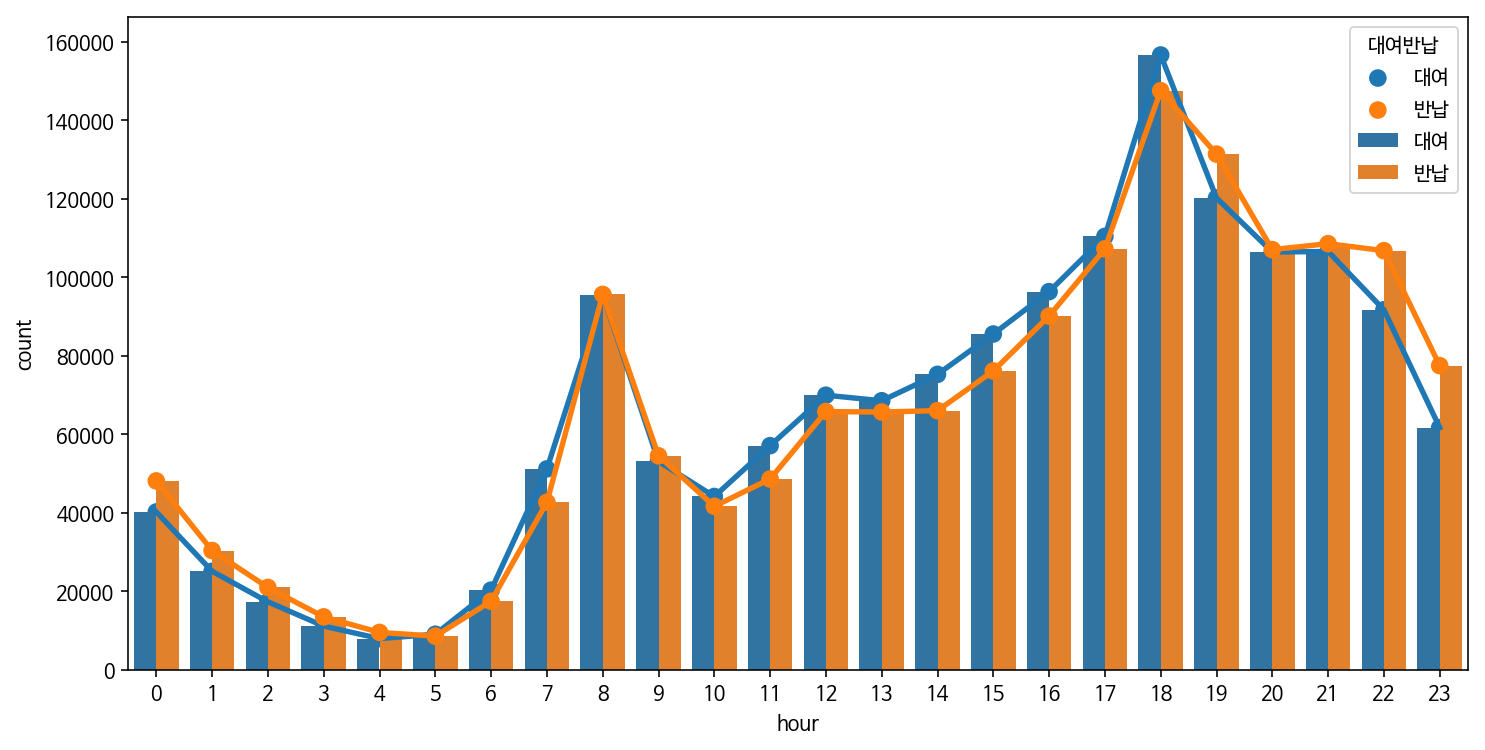

In [56]:
plt.figure(figsize=(12,6))
sns.pointplot(data=df_hour, x="hour", y="count", hue="대여반납")
sns.barplot(data=df_hour, x="hour", y="count", hue="대여반납")

* 새벽시간대로 갈 수록 대여/반납 수가 줄어든다.
* 출근시간대에는 대여가 반납보다 많다.
* 오전에는 8시대에 대여/반납이 많으며, 오후시간대에는 18시에 대여/반납이 가장 많다.
* 오전 11시부터 20시까지는 대여가 반납보다 많다.(대여>반납)
* 21시 이후부터 오전 4시까지는 대여보다 반납이 많다.(대여<반납)

In [57]:
df_minute_1 = df['대여분'].value_counts().reset_index()
df_minute_1.columns = ['minute', 'count']
df_minute_1 = df_minute_1.sort_values('minute')
df_minute_1['대여반납'] = '대여'
print(df_minute_1.shape)

df_minute_2 = df['반납분'].value_counts().reset_index()
df_minute_2.columns = ['minute', 'count']
df_minute_2 = df_minute_2.sort_values('minute')
df_minute_2['대여반납'] = '반납'
print(df_minute_2.shape)

df_minute = pd.concat([df_minute_1, df_minute_2])
print(df_minute.shape)

(60, 3)
(60, 3)
(120, 3)


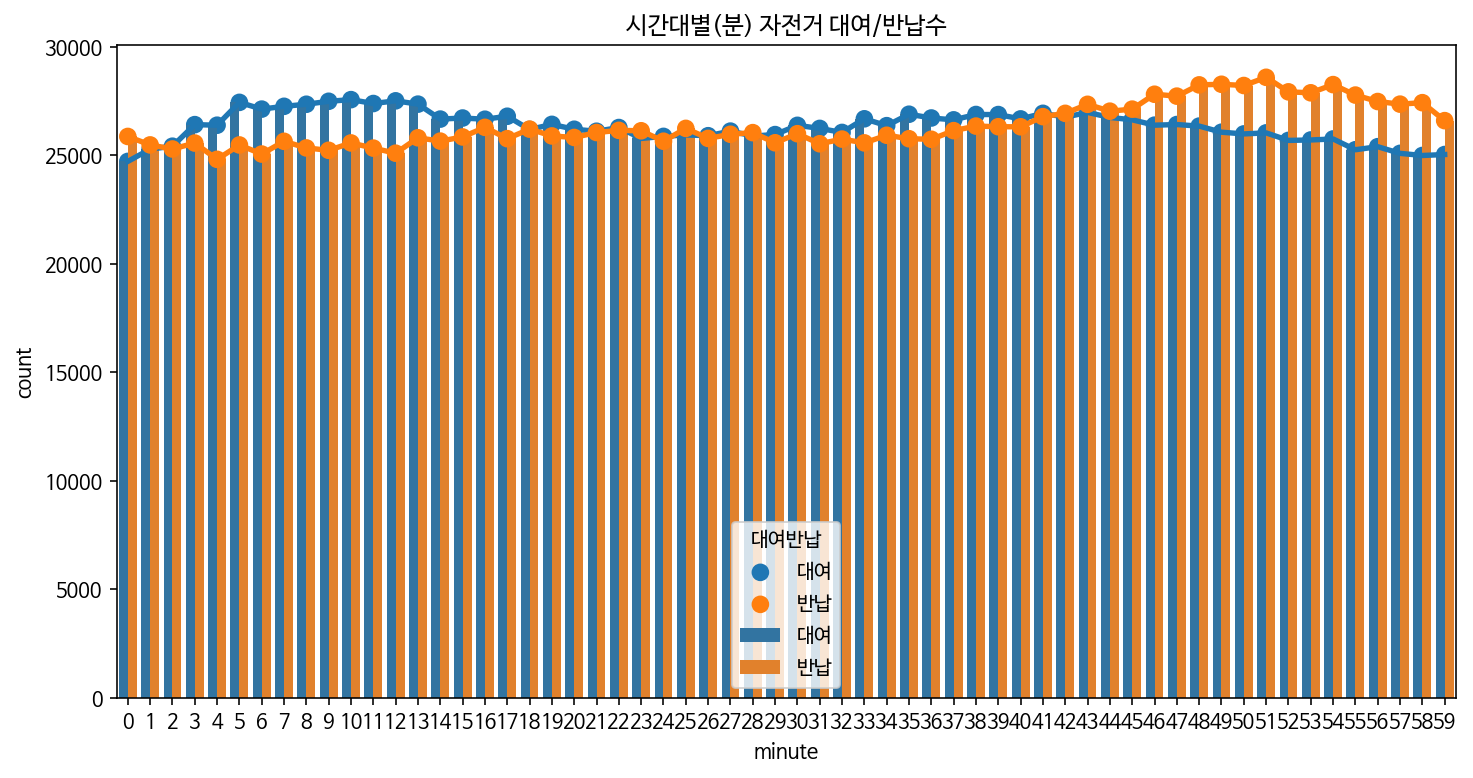

In [58]:
plt.figure(figsize=(12,6))
plt.title('시간대별(분) 자전거 대여/반납수')
sns.pointplot(data=df_minute, x="minute", y="count", hue="대여반납")
sns.barplot(data=df_minute, x="minute", y="count", hue="대여반납")

* 대여/반납이 거의 비슷하게 이루어지고 있지만 대여는 0 ~ 20분 사이에 더 많이 일어나며 반납은 40 ~ 60분 사이에 더 많이 일어난다.

## 대여와 반납은 같은 곳에서 이루어지고 있을까?

In [0]:
# 같은대여반납소라는 컬럼을 새로 만들고 대여반납이 같은 곳에서 이루어지고 있는지 여부를 추가한다.
df['같은대여반납소'] = df['대여대여소명'] == df['반납대여소명']

In [60]:
df_location_diff = df['같은대여반납소'].value_counts().reset_index()
df_location_diff.columns = ['일치여부', '대여반납수']
# 같은|다른 반납소별로 대여반납수가 몇 배나 차이가 나는지 확인한다.
location_diff_ratio = df_location_diff['대여반납수'][0]/df_location_diff['대여반납수'][1]
print(f'같은 곳에서 대여반납 하는 것보다 다른 곳에서 대여반납 하는 것이 {location_diff_ratio:.2f}배 많다.')
df_location_diff

같은 곳에서 대여반납 하는 것보다 다른 곳에서 대여반납 하는 것이 6.07배 많다.


,일치여부,대여반납수
0,False,1356795
1,True,223685


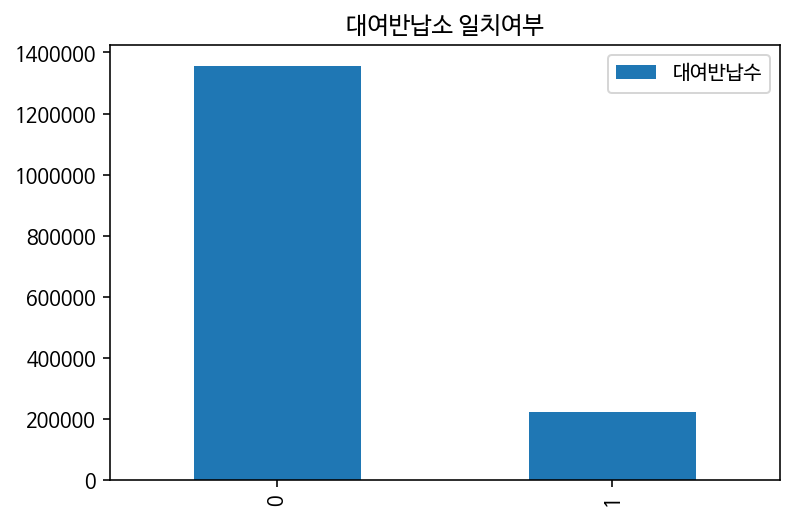

In [61]:
df_location_diff.plot.bar(title="대여반납소 일치여부")

같은 곳에서 대여반납을 하는 것보다 다른 곳으로의 대여반납이 훨씬 많은 것을 확인할 수 있다.

In [62]:
df_same_loc = df.loc[df['같은대여반납소'] == True]
df_same_loc.head()

,자전거번호,대여일시,대여대여소번호,대여대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),대여년월일,반납년월일,대여년,대여월,대여일,대여시,대여분,대여요일,반납년,반납월,반납일,반납시,반납분,반납요일,같은대여반납소
9,SPB-01089,2016-01-01 00:39:00,328,탑골공원 앞,5,2016-01-01 00:48:00,328,탑골공원 앞,5,8,0,2016-01-01,2016-01-01,2016,1,1,0,39,4,2016,1,1,0,48,4,True
13,SPB-01083,2016-01-01 00:57:00,122,신성기사식당 앞,1,2016-01-01 01:40:00,122,신성기사식당 앞,8,42,380,2016-01-01,2016-01-01,2016,1,1,0,57,4,2016,1,1,1,40,4,True
15,SPB-01089,2016-01-01 01:01:00,328,탑골공원 앞,5,2016-01-01 01:10:00,328,탑골공원 앞,5,9,310,2016-01-01,2016-01-01,2016,1,1,1,1,4,2016,1,1,1,10,4,True
16,SPB-00545,2016-01-01 01:02:00,328,탑골공원 앞,2,2016-01-01 01:10:00,328,탑골공원 앞,2,8,290,2016-01-01,2016-01-01,2016,1,1,1,2,4,2016,1,1,1,10,4,True
66,SPB-00903,2016-01-01 07:21:00,225,앙카라공원 앞,21,2016-01-01 08:30:00,225,앙카라공원 앞,21,68,9200,2016-01-01,2016-01-01,2016,1,1,7,21,4,2016,1,1,8,30,4,True


In [63]:
# 같은 곳에서 대여반납이 이루어지는 상위 대여소(대여|반납 건 수)
df_same_loc['대여대여소명'].value_counts().head(30)

 여의나루역 1번출구 앞      17515
 뚝섬유원지역 1번출구 앞     13692
 서울숲역 4번 출구 옆       6474
 서울시 공공자전거 상암센터     3615
 월드컵공원              2998
 월드컵경기장역 3번출구 옆     2831
 홈플러스 앞             2724
 산업은행 앞             2415
 국민일보 앞             2340
 홍대입구역 2번출구 앞       2186
 여의도고교 앞            2023
 여의도초교 앞            1896
 외국어대 정문 앞          1739
 서울숲 남문 버스정류소 옆     1721
 여의도중학교 옆           1686
 마포구민체육센터 앞         1671
 IFC몰               1667
 마포구청 앞             1666
 KBS 앞              1567
 옥수역 3번출구           1525
 누리꿈스퀘어 옆           1469
 삼부아파트1동 앞          1352
 서빙고동 주민센터 앞        1340
 서강대 정문 건너편         1326
 혜화동 로터리            1293
 당산육갑문              1290
 서강대 후문 옆           1249
 진미파라곤 앞            1240
 여의도역 1번출구 옆        1230
 망원역 1번출구 앞         1224
Name: 대여대여소명, dtype: int64

* 같은 곳에서 대여반납이 이루어지는 대여소들은 한강주변이나 공원 주변에 위치한 것을 확인해 볼 수 있다.

## 같은|다른 대여소에서 대여가 되는 자전거의 평균 이용시간
### 같은 대여반납소

In [64]:
same_loc_mean_time = df_same_loc['이용시간(분)'].mean()
print('같은곳에서 대여, 반납이 이루어지는 자전거의 평균 이용시간 : ', same_loc_mean_time)
df_same_mean = df_same_loc.groupby(['대여대여소명', '대여대여소번호', '반납대여소명'])['이용시간(분)'].mean().reset_index()
df_same_count = df_same_loc.groupby(['대여대여소명', '대여대여소번호', '반납대여소명']).size().reset_index()
df_same_count.columns = ['대여대여소명', '대여대여소번호', '반납대여소명', '이용횟수']
df_same_loc2 = df_same_mean.merge(df_same_count, left_on=['대여대여소명', '대여대여소번호', '반납대여소명'], 
                                  right_on=['대여대여소명', '대여대여소번호', '반납대여소명'])
df_same_loc2.sort_values(by='이용시간(분)', ascending=False).head(10)

같은곳에서 대여, 반납이 이루어지는 자전거의 평균 이용시간 :  51.08650557703914


,대여대여소명,대여대여소번호,반납대여소명,이용시간(분),이용횟수
299,연가초등학교 옆,167,연가초등학교 옆,88.349206,63
201,서울 월드컵 경기장,199,서울 월드컵 경기장,77.327239,547
146,목동사거리 부근,701,목동사거리 부근,77.068966,174
197,서부경찰서,918,서부경찰서,74.400000,5
78,금호역 1번출구 앞,522,금호역 1번출구 앞,73.914286,35
266,신정3동주민센터,707,신정3동주민센터,71.140000,150
11,KB국민은행 염창역 지점 앞,700,KB국민은행 염창역 지점 앞,70.281843,738
441,홍은사거리,117,홍은사거리,70.188119,101
345,응봉삼거리,535,응봉삼거리,69.839286,280
361,장안동 사거리,602,장안동 사거리,68.506944,288


In [65]:
# 이용횟수가 많은 곳의 평균 이용시간
df_same_loc2.sort_values(by='이용횟수', ascending=False).head(10)

,대여대여소명,대여대여소번호,반납대여소명,이용시간(분),이용횟수
291,여의나루역 1번출구 앞,207,여의나루역 1번출구 앞,63.791493,17515
120,뚝섬유원지역 1번출구 앞,502,뚝섬유원지역 1번출구 앞,57.487073,13692
210,서울숲역 4번 출구 옆,511,서울숲역 4번 출구 옆,62.813716,6474
211,서울시 공공자전거 상암센터,420,서울시 공공자전거 상암센터,62.829876,3615
334,월드컵공원,186,월드컵공원,58.345230,2998
333,월드컵경기장역 3번출구 옆,418,월드컵경기장역 3번출구 옆,54.421406,2831
436,홈플러스 앞,419,홈플러스 앞,68.116740,2724
169,산업은행 앞,205,산업은행 앞,51.936646,2415
64,국민일보 앞,202,국민일보 앞,52.142308,2340
437,홍대입구역 2번출구 앞,113,홍대입구역 2번출구 앞,53.206313,2186


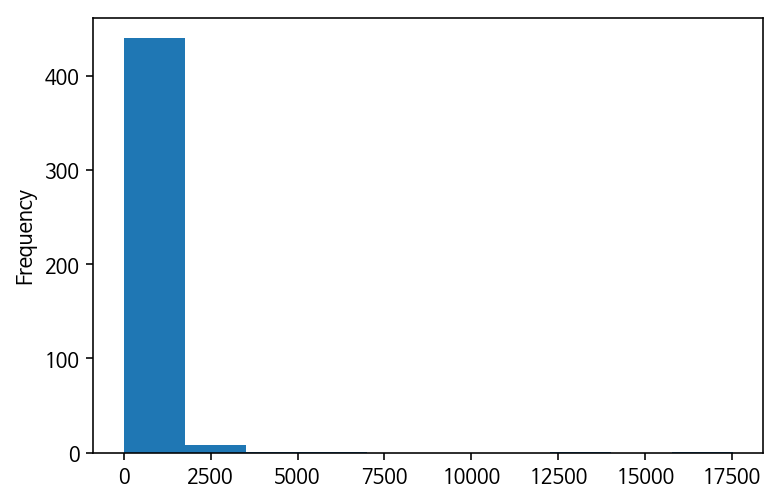

In [66]:
df_same_loc2['이용횟수'].plot.hist()

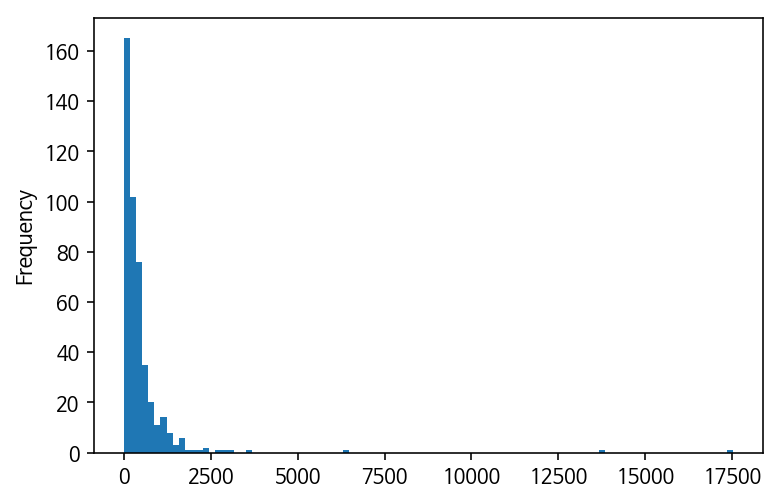

In [67]:
df_same_loc2['이용횟수'].plot.hist(bins=100)

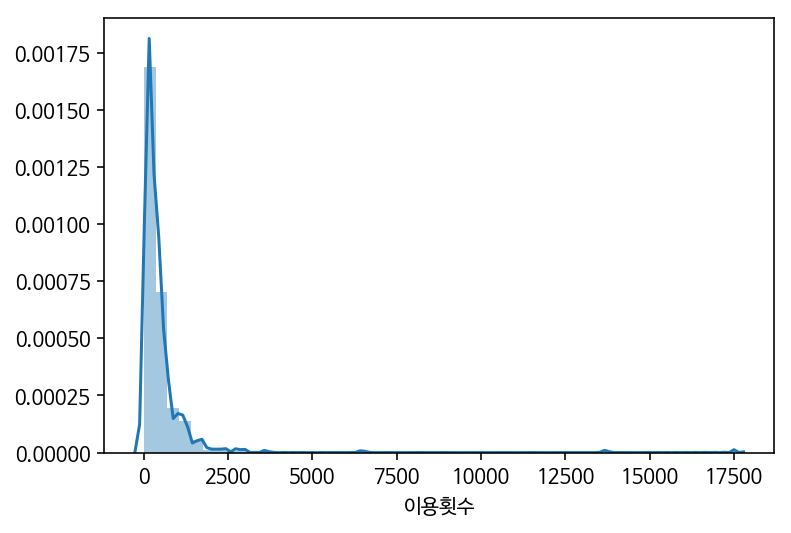

In [68]:
sns.distplot(df_same_loc2['이용횟수'])

### 다른 대여|반납소

In [69]:
df_diff_loc = df.loc[df['같은대여반납소'] == False]
df_diff_loc.shape

(1356795, 26)

In [70]:
diff_loc_mean_time = df_diff_loc['이용시간(분)'].mean()
print('다른곳에서 대여, 반납이 이루어지는 자전거의 평균 이용시간 : ', df_diff_loc['이용시간(분)'].mean())

df_diff_mean = df_diff_loc.groupby(
    ['대여대여소명', '반납대여소명'])['이용시간(분)'].mean().reset_index()
df_diff_count = df_diff_loc.groupby(
    ['대여대여소명', '반납대여소명']).size().reset_index()

df_diff_count.columns = ['대여대여소명', '반납대여소명', '이용횟수']
df_diff_loc2 = df_diff_mean.merge(df_diff_count, 
                                  left_on=['대여대여소명', '반납대여소명'], 
                                  right_on=['대여대여소명', '반납대여소명'])
df_diff_loc2.sort_values(by='이용시간(분)', ascending=False).head(10)

다른곳에서 대여, 반납이 이루어지는 자전거의 평균 이용시간 :  22.44472746435534


,대여대여소명,반납대여소명,이용시간(분),이용횟수
33572,신설동역 10번출구 앞,KEB 하나은행 본점 앞,1205.0,2
6037,광진구의회 앞,서울역9번출구,915.0,1
49261,종각역 1번출구 앞,영등포청과시장 사거리,797.0,1
40862,영등포구민체육센터 앞,여의도초교 앞,769.0,1
54824,충정2교,망원2빗물펌프장 앞,755.0,1
38616,여의나루역 1번출구 앞,자양나들목,699.0,1
30039,성균관대 E하우스 앞,독립문 어린이 공원,685.0,1
15895,롯데캐슬엠파이어 옆,서빙고동 금호맨션 앞,631.0,1
25704,서대문역 3번출구 뒤,을지로2가 사거리 남측,613.0,1
1757,KB국민은행 염창역 지점 앞,서울숲역 4번 출구 옆,538.0,1


In [71]:
df_diff_loc2.sort_values(by='이용횟수', ascending=False).head(10)

,대여대여소명,반납대여소명,이용시간(분),이용횟수
58704,홍대입구역 2번출구 앞,일진아이윌아파트 옆,10.732824,2620
46860,일진아이윌아파트 옆,홍대입구역 2번출구 앞,8.105614,2547
55919,하늘채코오롱아파트 건너편,홍대입구역 2번출구 앞,8.712074,1938
882,DMC역 9번출구 앞,누리꿈스퀘어 옆,7.382220,1766
38420,여의나루역 1번출구 앞,국민일보 앞,17.911429,1750
6011,광진구의회 앞,뚝섬유원지역 1번출구 앞,39.423341,1748
37083,앙카라공원 앞,시범아파트버스정류장 옆,6.767456,1690
58649,홍대입구역 2번출구 앞,신한은행 서교동금융센터점 앞,13.776398,1610
855,DMC역 9번출구 앞,DMC산학협력연구센터 앞,5.638617,1533
28145,서울시립대 정문 앞,서울시립대 후문,8.934254,1521


In [72]:
rent_mean_time = same_loc_mean_time - diff_loc_mean_time
print(f'같은 곳에서 대여반납이 이루어지는 자전거의 이용시간(분)이 다른 대여소의 대여반납 이용시간보다 {rent_mean_time:.2f} 분 많다.')

같은 곳에서 대여반납이 이루어지는 자전거의 이용시간(분)이 다른 대여소의 대여반납 이용시간보다 28.64 분 많다.


* 이용횟수가 많은 대여소라고 해서 평균이용시간이 평균보다 높지는 않다.
* 하늘채코오롱아파트 건너편<->홍대입구역 2번출구 앞은 이용횟수가 가장 높은 대여반납소다.
* 관련기사
    * ['따릉이' 타고 가장 많이 다닌 경로는? - 통플러스](http://news.tongplus.com/site/data/html_dir/2018/10/24/2018102402585.html)
    * [[ONE SHOT] 따릉이, ‘이곳’서 가장 많이 빌리고 ‘여기’서 가장 많이 탄다](https://news.joins.com/article/23003297)

## 해당 기간동안 가장 많이 이용된 자전거는 몇 회 대여 되었을까?

In [73]:
bike_describe = df['자전거번호'].describe()
print('대여된 자전거 수 :', bike_describe[1])
print('가장 많이 대여된 자전거 번호 :', bike_describe[2])
print('가장 많이 대여된 자전거의 대여횟수 :', bike_describe[3])
bike_describe

대여된 자전거 수 : 4954
가장 많이 대여된 자전거 번호 : SPB-00438
가장 많이 대여된 자전거의 대여횟수 : 701


count       1580480
unique         4954
top       SPB-00438
freq            701
Name: 자전거번호, dtype: object

In [74]:
bike_rent_counts = df['자전거번호'].value_counts().reset_index()
bike_rent_counts.columns = ['자전거번호', '대여수']
print('해당 기간동안 자전거 하나당 평균 대여 수:', bike_rent_counts['대여수'].mean())
print('자전거 하나당 가장 많이 대여된 횟수:', bike_rent_counts['대여수'].max())
print('자전거 하나당 가장 적게 대여된 횟수:', bike_rent_counts['대여수'].min())

해당 기간동안 자전거 하나당 평균 대여 수: 319.0310859911183
자전거 하나당 가장 많이 대여된 횟수: 701
자전거 하나당 가장 적게 대여된 횟수: 1


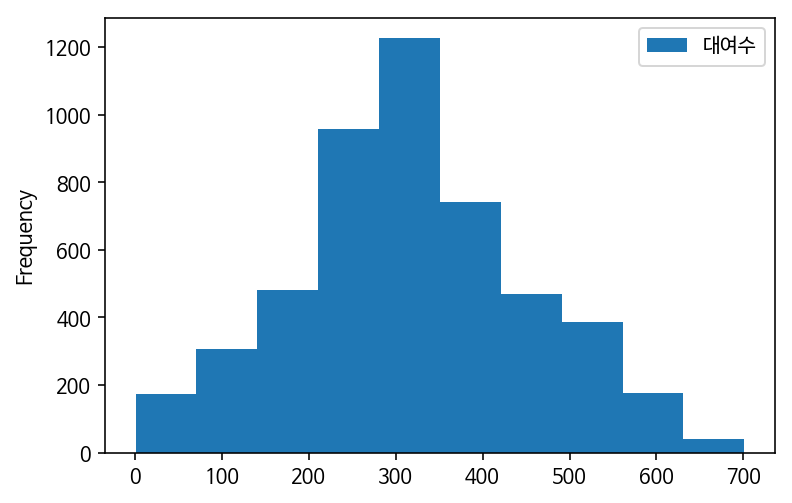

In [75]:
bike_rent_counts.plot.hist()

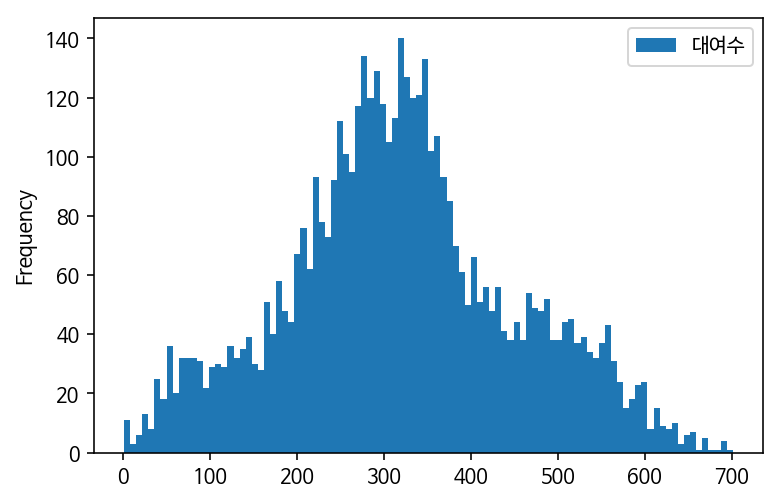

In [76]:
# bin의 갯수를 늘려서 그려본다.
bike_rent_counts.plot.hist(bins=100)

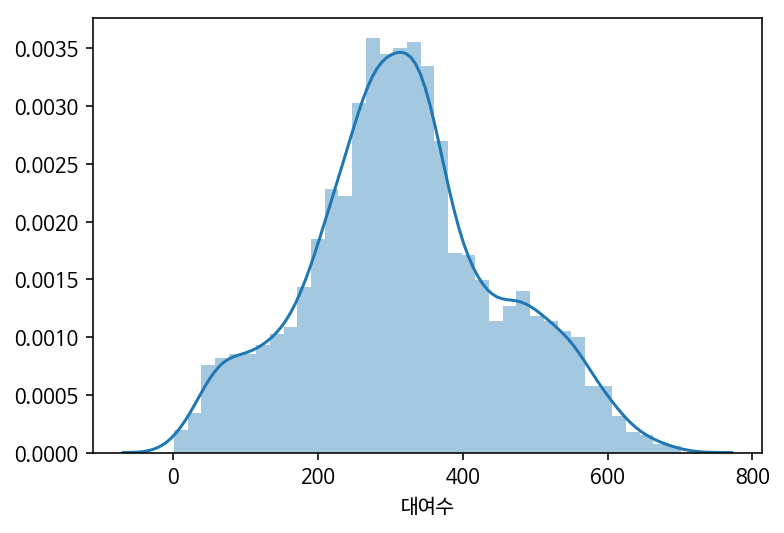

In [77]:
sns.distplot(bike_rent_counts["대여수"])

In [78]:
# 가장 많이 대여된 자전거의 대여이력
most_bike_df = df.loc[df['자전거번호'] == bike_describe[2]]
most_bike_df.head()

,자전거번호,대여일시,대여대여소번호,대여대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간(분),이용거리(M),대여년월일,반납년월일,대여년,대여월,대여일,대여시,대여분,대여요일,반납년,반납월,반납일,반납시,반납분,반납요일,같은대여반납소
36,SPB-00438,2016-01-01 02:40:00,108,서교동 사거리,6,2016-01-01 03:09:00,122,신성기사식당 앞,4,28,2560,2016-01-01,2016-01-01,2016,1,1,2,40,4,2016,1,1,3,9,4,False
42,SPB-00438,2016-01-01 03:16:00,122,신성기사식당 앞,4,2016-01-01 03:21:00,118,광흥창역 2번출구 앞,9,4,680,2016-01-01,2016-01-01,2016,1,1,3,16,4,2016,1,1,3,21,4,False
457,SPB-00438,2016-01-01 22:07:00,118,광흥창역 2번출구 앞,3,2016-01-01 22:10:00,120,신수동 사거리,2,2,470,2016-01-01,2016-01-01,2016,1,1,22,7,4,2016,1,1,22,10,4,False
566,SPB-00438,2016-01-02 08:47:00,120,신수동 사거리,2,2016-01-02 08:51:00,124,서강대 정문 건너편,1,4,780,2016-01-02,2016-01-02,2016,1,2,8,47,5,2016,1,2,8,51,5,False
859,SPB-00438,2016-01-02 16:14:00,124,서강대 정문 건너편,1,2016-01-02 18:41:00,106,합정역 7번출구 앞,8,146,28530,2016-01-02,2016-01-02,2016,1,2,16,14,5,2016,1,2,18,41,5,False


In [79]:
most_bike_df['대여대여소명'].value_counts()

 여의나루역 1번출구 앞         19
 홍대입구역 2번출구 앞         17
 여의도역 4번출구 옆          11
 혜화역 3번출구 뒤           10
 안국역 5번출구 앞            9
 홍대입구역 8번출구 앞          9
 사루비아 빌딩 앞             9
 창천문화공원                8
 누리꿈스퀘어 옆              8
 세운스퀘어 앞               8
 시범아파트버스정류장 옆          8
 KT앞                   8
 종로4가 사거리              7
 서울광장 옆                7
 청계2가 사거리 옆            7
 서강대 후문 옆              7
 서울숲역 4번 출구 옆          7
 증권거래소 앞               7
 혜화동 로터리               7
 마포구 육아종합지원센터          7
 DMC홍보관                6
 상암월드컵파크 9단지 앞         6
 하늘채코오롱아파트 건너편         6
 티마크 호텔 앞              6
 신한은행 서교동금융센터점 앞       6
 국민일보 앞                6
 IFC몰                  6
 여의도초교 앞               6
 DMC산학협력연구센터 앞         6
 국립현대미술관               6
                      ..
 KT혜화지사 앞              1
 답십리역 1번출구             1
 KAIST 경영대학 앞          1
 청량리 기업은행 앞            1
 창신역 1번출구 앞            1
 마포역 1번출구 뒤            1
 서강대 정문 건너편            1
 을지로2가 사거리 남측          1
 종각역 5번출구              1


In [80]:
rent_station = most_bike_df['대여대여소명'].unique()
rent_station

array([' 서교동 사거리', ' 신성기사식당 앞', ' 광흥창역 2번출구 앞', ' 신수동 사거리', ' 서강대 정문 건너편',
       ' 서울 중앙우체국 앞', ' 명동성당 앞', ' 맥스타일 앞', ' 성수아카데미타워 앞', ' 혜화역 3번출구 뒤',
       ' 탑골공원 앞', ' 서울역 광장 파출소 옆', ' 서울광장 옆', ' 종각역 1번출구 앞',
       ' KEB 하나은행 본점 앞', ' 성균관대 E하우스 앞', ' 낙원상가 옆', ' 안국역 5번출구 앞',
       ' 국립현대미술관', ' 신한은행 안국역지점 옆', ' 정동사거리', ' 청계광장 옆', ' 서울보증보험본사 앞',
       ' 혜화동 로터리', ' 세운스퀘어 앞', ' 예일빌딩(율곡로) 앞', ' 창경궁 입구', ' 경복궁역 4번출구 뒤',
       ' 경복궁역 7번출구 앞', ' 광화문역 1번출구 앞', ' 시청역 1번출구 뒤', ' 광화문역 2번출구 앞',
       ' 을지로입구역 4번출구 앞', ' 종로4가 사거리', ' 청계2가 사거리 옆', ' 종로3가역 15번출구 앞',
       ' 티마크 호텔 앞', ' 광화문역 7번출구 앞', ' 광교사거리 남측', ' DMC산학협력연구센터 앞',
       ' 누리꿈스퀘어 옆', ' DMC홍보관', ' 상암월드컵파크 1단지 교차로', ' 상암한화오벨리스크 1차 앞',
       ' 월드컵경기장역 3번출구 옆', ' 마포구 육아종합지원센터', ' 서울시 공공자전거 상암센터',
       ' DMC역 9번출구 앞', ' DMC빌 앞', ' DMC역 2번출구 옆', ' 신촌역(2호선) 6번출구 옆',
       ' 홍대입구역 8번출구 앞', ' 제일빌딩 앞', ' 사루비아 빌딩 앞', ' 합정역 5번출구 앞',
       ' (구)합정동 주민센터', ' 망원역 2번출구 앞', ' 상수역 2번출구 앞', ' 여의도역 4번출구 옆',
       ' 서울숲역 4번 출구 옆', ' 서울숲 남문 버

In [81]:
# 대여소명 앞에 들어간 공백을 제거합니다.
bike_move = []
for s in rent_station:
    bike_move.append(s.strip())
    
bike_move    

['서교동 사거리',
 '신성기사식당 앞',
 '광흥창역 2번출구 앞',
 '신수동 사거리',
 '서강대 정문 건너편',
 '서울 중앙우체국 앞',
 '명동성당 앞',
 '맥스타일 앞',
 '성수아카데미타워 앞',
 '혜화역 3번출구 뒤',
 '탑골공원 앞',
 '서울역 광장 파출소 옆',
 '서울광장 옆',
 '종각역 1번출구 앞',
 'KEB 하나은행 본점 앞',
 '성균관대 E하우스 앞',
 '낙원상가 옆',
 '안국역 5번출구 앞',
 '국립현대미술관',
 '신한은행 안국역지점 옆',
 '정동사거리',
 '청계광장 옆',
 '서울보증보험본사 앞',
 '혜화동 로터리',
 '세운스퀘어 앞',
 '예일빌딩(율곡로) 앞',
 '창경궁 입구',
 '경복궁역 4번출구 뒤',
 '경복궁역 7번출구 앞',
 '광화문역 1번출구 앞',
 '시청역 1번출구 뒤',
 '광화문역 2번출구 앞',
 '을지로입구역 4번출구 앞',
 '종로4가 사거리',
 '청계2가 사거리 옆',
 '종로3가역 15번출구 앞',
 '티마크 호텔 앞',
 '광화문역 7번출구 앞',
 '광교사거리 남측',
 'DMC산학협력연구센터 앞',
 '누리꿈스퀘어 옆',
 'DMC홍보관',
 '상암월드컵파크 1단지 교차로',
 '상암한화오벨리스크 1차 앞',
 '월드컵경기장역 3번출구 옆',
 '마포구 육아종합지원센터',
 '서울시 공공자전거 상암센터',
 'DMC역 9번출구 앞',
 'DMC빌 앞',
 'DMC역 2번출구 옆',
 '신촌역(2호선) 6번출구 옆',
 '홍대입구역 8번출구 앞',
 '제일빌딩 앞',
 '사루비아 빌딩 앞',
 '합정역 5번출구 앞',
 '(구)합정동 주민센터',
 '망원역 2번출구 앞',
 '상수역 2번출구 앞',
 '여의도역 4번출구 옆',
 '서울숲역 4번 출구 옆',
 '서울숲 남문 버스정류소 옆',
 '뚝섬역 1번 출구 옆',
 '광진메디칼 앞',
 '성수아이에스비즈타워 앞',
 '광진구의회 앞',
 '광양중학교 앞',
 '자양사거리 광진아크로텔 앞',
 '어린이대공원

In [82]:
stations = pd.read_csv('data/seoul_bike_station.csv')
stations.shape

(1529, 7)

In [83]:
bike_move_df = pd.DataFrame(bike_move)
bike_move_df.columns = ['대여소']
print(bike_move_df.shape)
bike_move_df.head()

(223, 1)


,대여소
0,서교동 사거리
1,신성기사식당 앞
2,광흥창역 2번출구 앞
3,신수동 사거리
4,서강대 정문 건너편


In [84]:
bike_move_df = bike_move_df.merge(stations, left_on='대여소', right_on='대여소', how='left')
bike_move_df.shape

(223, 7)

In [85]:
bike_move_df.head()

,대여소,대여소번호,거치대수,상태,주소,위도,경도
0,서교동 사거리,108.0,10.0,운영중,서울특별시 마포구 양화로 93 427,37.552746,126.918617
1,신성기사식당 앞,122.0,10.0,운영중,서울특별시 마포구 독막로 223-1 50-2,37.547459,126.938377
2,광흥창역 2번출구 앞,118.0,10.0,운영중,서울특별시 마포구 독막로 지하165 243-3,37.547733,126.931763
3,신수동 사거리,120.0,5.0,운영중,서울특별시 마포구 토정로 211 371-11,37.545242,126.934113
4,서강대 정문 건너편,124.0,20.0,운영중,서울특별시 마포구 서강로16길 72 84-5,37.551140,126.936989


In [86]:
bike_move_df.isnull().sum()

대여소      0
대여소번호    7
거치대수     7
상태       7
주소       7
위도       7
경도       7
dtype: int64

## 가장 많이 대여된 자전거가 거쳐간 대여소

In [87]:
# 정보가 없는 대여소, 위경도를 주소정보 등으로 다시 가져올 필요가 있다.
bike_move_df.loc[bike_move_df['경도'].isnull()]

,대여소,대여소번호,거치대수,상태,주소,위도,경도
5,서울 중앙우체국 앞,NaN,NaN,NaN,NaN,NaN,NaN
14,KEB 하나은행 본점 앞,NaN,NaN,NaN,NaN,NaN,NaN
61,뚝섬역 1번 출구 옆,NaN,NaN,NaN,NaN,NaN,NaN
80,창천문화공원,NaN,NaN,NaN,NaN,NaN,NaN
135,서대문소방서,NaN,NaN,NaN,NaN,NaN,NaN
190,마포역 1번출구 뒤,NaN,NaN,NaN,NaN,NaN,NaN
207,충정로역 7번출구 뒤,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# 지도 표현을 위해 folium 을 import 한다.
# 데이터 프레임에서 위도와 경도의 평균값을 구한다. 이 값으로 지도의 중심이 될 좌표를 정한다.
# zoom_start는 지도를 얼마나 확대해서 볼것인지다.
# tiles는 지도의 스타일이다.

import folium 

geo_df = bike_move_df
map = folium.Map(
    location=[geo_df['위도'].mean(), geo_df['경도'].mean()], 
    zoom_start=12, tiles='Stamen Toner')

for n in geo_df.index:
    if geo_df.loc[n, '위도'] > 0 and geo_df.loc[n, '경도'] > 0 :
        loc_name = geo_df.loc[n, '대여소']

        icon_color = 'red'
        folium.Circle(
            location=[geo_df.loc[n, '위도'], geo_df.loc[n, '경도']],
            popup=loc_name,
            radius=50,
            color=icon_color,
            fill=True,
            fill_color=icon_color
        ).add_to(map)
    
map